### 8.	Portfolio optimization

Modern portfolio theory (MPT) can be considered one of the biggest successes of statistics in finance. Starting in the early 1950s with the work of pioneer Harry Markowitz, this theory began to replace people’s reliance on judgment and experience with rigorous mathematical and statistical methods when it comes to the investment of money in financial markets. In that sense, it is maybe the first real quantitative model and approach in finance. For illustration, let's download financial data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

data = yf.download('SPY AAPL MSFT GLD', start = '2016-12-01', end = '2019-12-31', period = '1d')
data = data['Adj Close']

rets = np.log(data / data.shift(1))
rets

[*********************100%***********************]  4 of 4 completed


,AAPL,GLD,MSFT,SPY
Date,,,,
2016-11-30,NaN,NaN,NaN,NaN
2016-12-01,-0.009363,-0.001881,-0.017747,-0.003682
2016-12-02,0.003738,0.005365,0.000844,0.000501
2016-12-05,-0.007214,-0.005365,0.016238,0.005991
2016-12-06,0.007669,-0.000987,-0.004493,0.003163
...,...,...,...,...
2019-12-23,0.016187,0.003077,0.000000,0.001527
2019-12-24,0.000950,0.009388,-0.000191,0.000031
2019-12-26,0.019646,0.007827,0.008163,0.005309


Of paramount interest to investors is what risk-return profiles are possible for a given set of financial instruments, and their statistical characteristics. The following implements a Monte Carlo simulation to generate random portfolio weight vectors. For every simulated allocation, the code records the resulting expected portfolio return and variance. To simplify the code, two functions **portfolio_ret()** and **portfolio_vol()** are defined:

In [2]:
def portfolio_ret(weights):
    return np.dot(rets.mean(), weights) * 252

def portfolio_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov(), weights)) * 252)

portfolio_rets = []
portfolio_vols = []

for p in range (2500):
    np.random.seed(p + 1)
    weights = np.random.rand(rets.shape[1])
    weights /= np.sum(weights)
    
    portfolio_rets.append(portfolio_ret(weights))
    portfolio_vols.append(portfolio_vol(weights))
    
portfolio_rets = np.array(portfolio_rets)
portfolio_vols = np.array(portfolio_vols)

portfolio_rets

array([0.16556517, 0.26964676, 0.19778606, ..., 0.28346342, 0.25497979,
       0.17216521])

2500

The following illustrates the results of the Monte Carlo simulation graphically. In addition, it provides results for the Sharpe ratio, defined as $SR = \frac{(\mu_p − r_f)}{σ_p}$, i.e., the excess expected return of the portfolio over the risk-free rate $r_f$ divided by the expected standard deviation of the portfolio. For simplicity, $r_f = 0$ is assumed.

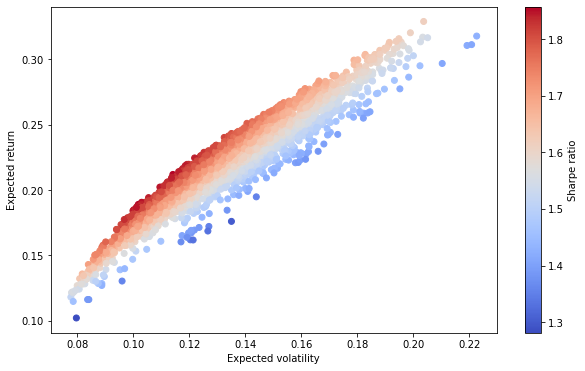

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_vols,
            portfolio_rets,
            c=portfolio_rets / portfolio_vols,
            marker='o',
            cmap='coolwarm')
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio')

It is clear by inspection that not all weight distributions perform well when measured in terms of mean and volatility. For example, for a fixed risk level of, say, 14%, there are multiple portfolios that all show different returns. As an investor, one is generally interested in the maximum return given a fixed risk level or the minimum risk given a fixed return expectation. This set of portfolios then makes up the so-called _efficient frontier_. 

**_The maximization of the Sharpe ratio_**. Formally, the negative value of the Sharpe ratio is minimized to derive the maximum value and the optimal portfolio composition. The constraint is that all weights add up to 1. This can be formulated as follows using the conventions of the **.minimize()** (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) function from **scipy.optimize** sub-package. The weights are also bound to be between 0 and 1. These values are provided to the minimization function as a tuple of tuples.

The only input that is missing for the optimization function is a starting parameter list (initial guess for the weights vector). An equal distribution of weights will do:

In [5]:
import scipy.optimize as sco

def min_sharpe(weights):
    return -portfolio_ret(weights) / portfolio_vol(weights)

cons = ({'type': 'eq',
         'fun': lambda x: np.sum(x) - 1})

bnds = tuple((0, 1) for x in range(rets.shape[1]))
bnds

((0, 1), (0, 1), (0, 1), (0, 1))

In [6]:
equal_w = np.array(rets.shape[1] * [1 / rets.shape[1]])
equal_w

array([0.25, 0.25, 0.25, 0.25])

In [7]:
min_sharpe(equal_w)

-1.6885732769473958

Calling the function returns optimal parameter values. The results are stored in an object called **optimal**. The main interest lies in getting the optimal portfolio composition. One can access the results object by providing the key of interest, **x** in this case:

In [8]:
optimal = sco.minimize(min_sharpe,
                       equal_w,
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)
optimal

     fun: -1.8703123742823657
     jac: array([-0.0020199 ,  0.00096184, -0.00046347,  0.2454356 ])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.1774282 , 0.51894521, 0.30362658, 0.        ])

In [9]:
optimal['x'].round(3)

array([0.177, 0.519, 0.304, 0.   ])

In [10]:
portfolio_ret(optimal['x']).round(3)

0.2

In [11]:
portfolio_vol(optimal['x']).round(3)

0.107

In [12]:
portfolio_ret(optimal['x']) / portfolio_vol(optimal['x'])

1.8703123742823657

**_The minimization of the variance of the portfolio_**. This is the same as minimizing the volatility:

In [13]:
optivol = sco.minimize(portfolio_vol,
                       equal_w,
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)
optivol

     fun: 0.0750023335407177
     jac: array([0.09663828, 0.07521471, 0.10839812, 0.07470241])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([5.20417043e-18, 5.85449476e-01, 0.00000000e+00, 4.14550524e-01])

In [14]:
optivol['x'].round(3)

array([0.   , 0.585, 0.   , 0.415])

In [15]:
portfolio_ret(optivol['x']).round(3)

0.106

In [16]:
portfolio_vol(optivol['x']).round(3)

0.075

In [17]:
portfolio_ret(optivol['x']) / portfolio_vol(optivol['x'])

1.410155275299119

This portfolio leads to the so-called minimum volatility or minimum variance portfolio.

The derivation of all optimal portfolios — i.e., all portfolios with minimum volatility for a given target return level (or all portfolios with maximum return for a given risk level) — is similar to the previous optimizations. The only difference is that one has to iterate over multiple starting conditions.

The approach taken is to fix a target return level and to derive for each such level those portfolio weights that lead to the minimum volatility value. For the optimization, this leads to two conditions: one for the target return level, **target_ret**, and one for the sum of the portfolio weights as before. The boundary values for each parameter stay the same. When iterating over different target return levels, one condition for the minimization changes. That is why the constraints dictionary is updated during every loop:

In [18]:
cons = ({'type': 'eq',
         'fun': lambda x: portfolio_ret(x) - target_ret},
        {'type': 'eq',
         'fun': lambda x: np.sum(x) - 1})

bnds = tuple((0, 1) for x in weights)
target_rets = np.linspace(0.1, 0.25, 26)
target_vols = []

for target_ret in target_rets:
    res = sco.minimize(portfolio_vol,
                       equal_w,
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)
    target_vols.append(res['fun'])

target_vols = np.array(target_vols)
target_vols

array([0.07673745, 0.07500328, 0.07584671, 0.07707761, 0.07846903,
       0.08000978, 0.08169137, 0.08350498, 0.08544252, 0.08749578,
       0.08965545, 0.09191508, 0.0942679 , 0.09670676, 0.09922497,
       0.10191592, 0.10485141, 0.10801138, 0.11137669, 0.11493189,
       0.11865288, 0.12253059, 0.12654972, 0.13069587, 0.13495836,
       0.13932616])

The following shows the optimization results. Crosses indicate the optimal portfolios given a certain target return; the dots are, as before, the random portfolios. In addition, the figure shows two larger stars: one for the minimum volatility portfolio (the leftmost portfolio) and one for the portfolio with the maximum Sharpe ratio:

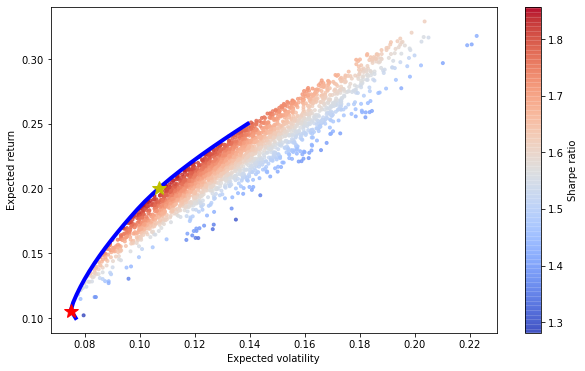

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_vols, portfolio_rets,
            c=portfolio_rets / portfolio_vols,
            marker='.',
            alpha=0.8,
            cmap='coolwarm')
plt.plot(target_vols, target_rets,
         'b',
         lw=4.0)
plt.plot(portfolio_vol(optimal['x']), portfolio_ret(optimal['x']),
         'y*',
         markersize=15.0)
plt.plot(portfolio_vol(optivol['x']), portfolio_ret(optivol['x']),
         'r*',
         markersize=15.0)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio')

The _efficient frontier_ is comprised of all optimal portfolios with a higher return than the absolute minimum variance portfolio. These portfolios dominate all other portfolios in terms of expected returns given a certain risk level.

In addition to risky financial instruments like stocks or commodities, there is one universal, riskless investment opportunity available: cash or cash accounts. In an idealized world, money held in a cash account with a large bank can be considered riskless (e.g., through public deposit insurance schemes). The downside is that such a riskless investment generally yields only a small return, sometimes close to zero.

However, taking into account such a riskless asset, enhances the efficient investment opportunity set for investors considerably. The basic idea is that investors first determine an efficient portfolio of risky assets and then add the riskless asset to the mix. By adjusting the proportion of the investor’s wealth to be invested in the riskless asset it is possible to achieve any risk-return profile that lies on the straight line (in the risk-return space) between the riskless asset and the efficient portfolio.

Which efficient portfolio (out of the many options) is to be taken to invest in optimally? It is the one portfolio where the tangent line of the efficient frontier goes exactly through the risk-return point of the riskless portfolio. For example, consider a riskless interest rate of $r_f = $0.01. The portfolio is to be found on the efficient frontier for which the tangent goes through the point $(\sigma_f, r_f) = $(0, 0.01) in risk-return space.

For the calculations to follow, a functional approximation and the first derivative for the efficient frontier are used. _Cubic splines_ interpolation provides such a differentiable functional approximation, using **.splrep()** (https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html#scipy.interpolate.splrep) and **.splev()** (https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splev.html#scipy.interpolate.splev) functions from **scipy.interpolate** (https://docs.scipy.org/doc/scipy/reference/interpolate.html) sub-package. For the spline interpolation, only portfolios from the efficient frontier are used. Via this numerical approach it is possible to define a continuously differentiable function **f(x)** for the efficient frontier and the respective first derivative function **df(x)**:

In [2]:
import scipy.interpolate as sci

index = np.argmin(target_vols)
t_vols = target_vols[index:]
t_rets = target_rets[index:]

tck = sci.splrep(t_vols, t_rets)

def f(x):
    return sci.splev(x, tck, der=0)
         
def df(x):
    return sci.splev(x, tck, der=1)

tck

NameError: name 'np' is not defined

What is now to be derived is a linear function $t(x) = a + b⋅x$ representing the line that passes through the riskless asset in risk-return space and that is tangent to the efficient frontier. Mathematical conditions for _capital market line_ describes all three conditions that the function $t(x)$ needs to satisfy.

Since there is no closed formula for the efficient frontier or the first derivative of it, one has to solve the system of equations in mathematical conditions for _capital market line_ numerically. Define a Python function **equations()** that returns the values of all three equations given the parameter set $p = (a, b, x)$.

The function **.fsolve()** (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html) from **scipy.optimize** sub-package is capable of solving such a system of equations. In addition to the function **equations()**, an initial parameterization is provided. Note that success or failure of the optimization might depend on the initial parameterization, which therefore has to be chosen carefully — generally by a combination of educated guesses with trial and error:

In [21]:
def equations(p, rf=0.01):
    equation_1 = rf - p[0]
    equation_2 = rf + p[1] * p[2] - f(p[2])
    equation_3 = p[1] - df(p[2])
    return equation_1, equation_2, equation_3

opt = sco.fsolve(equations, [0.01, 2, 0.1])  
opt

array([0.01      , 1.77807954, 0.10981373])

In [22]:
np.round(equations(opt), 6)

array([ 0.,  0., -0.])

The following presents the results graphically: the star represents the optimal portfolio from the efficient frontier for which the tangent line passes through the riskless asset point (0, $r_f = $0.01):

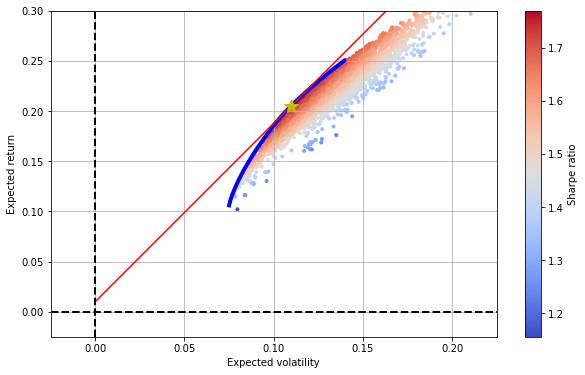

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_vols, portfolio_rets,
            c=(portfolio_rets - 0.01) / portfolio_vols,
            marker='.',
            cmap='coolwarm')
plt.plot(t_vols, t_rets,
         'b',
         lw=4.0)
cx = np.linspace(0.0, 0.3, 61)
plt.plot(cx, opt[0] + opt[1] * cx,
         'r',
         lw=1.5)
plt.plot(opt[2], f(opt[2]),
         'y*',
         markersize=15.0)
plt.grid(True)
plt.axhline(0,
            color='k',
            ls='--',
            lw=2.0)
plt.axvline(0,
            color='k',
            ls='--',
            lw=2.0)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.xlim([-0.025, 0.225])
plt.ylim([-0.025, 0.3])
plt.colorbar(label='Sharpe ratio')

The portfolio weights of the optimal (tangent) portfolio are as follows:

In [24]:
cons = ({'type': 'eq',
         'fun': lambda x:  portfolio_ret(x) - f(opt[2])},
        {'type': 'eq',
         'fun': lambda x:  np.sum(x) - 1})

result = sco.minimize(portfolio_vol,
                      equal_w,
                      method='SLSQP',
                      bounds=bnds,
                      constraints=cons)
result

     fun: 0.10981418709388738
     jac: array([0.18031988, 0.03905393, 0.18029705, 0.09259901])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.18347626, 0.49904767, 0.31747607, 0.        ])

In [25]:
result['x'].round(3)

array([0.183, 0.499, 0.317, 0.   ])

In [26]:
portfolio_ret(result['x'])

0.20525755223193695

In [27]:
portfolio_vol(result['x'])

0.10981418709388738

In [28]:
portfolio_ret(result['x']) / portfolio_vol(result['x'])

1.8691351059808763

**_Exercises._**

Exercise 1. Obtain an efficient frontier for the following stocks, but allow for short sales (weights between -1 and 1). Plot the standard (long only) efficient frontier and compare the two. What do you notice?

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
import yfinance as yf

data = yf.download('TSLA AAPL MSFT AAPL NFLX BAC UAL MMM CVX XOM', start = '2016-01-01', end = '2019-12-31', period = '1d')
data = data['Adj Close'].resample('1m').last()

rets = np.log(data / data.shift(1))
rets.head()

[*********************100%***********************]  9 of 9 completed


,AAPL,BAC,CVX,MMM,MSFT,NFLX,TSLA,UAL,XOM
Date,,,,,,,,,
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-31,-0.078223,-0.174155,-0.039567,0.002387,-0.007055,-0.219478,-0.227361,-0.171283,-0.001284
2016-02-29,-0.001289,-0.121680,-0.023066,0.045337,-0.072344,0.016951,0.003811,0.170585,0.038151
2016-03-31,0.119746,0.080641,0.133951,0.060359,0.082036,0.090227,0.179948,0.044406,0.042024
2016-04-30,-0.150731,0.074108,0.068657,0.004491,-0.102087,-0.127082,0.046722,-0.267506,0.055948


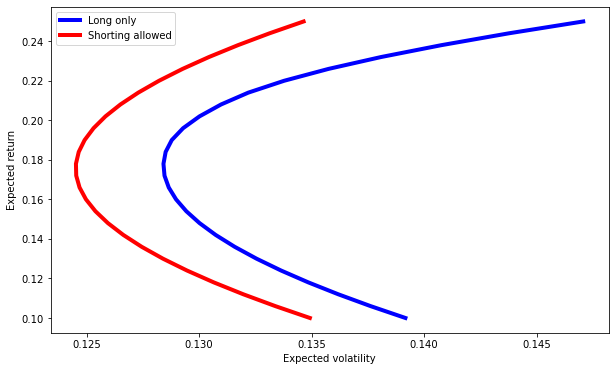

In [30]:
def portfolio_ret(weights):
    return np.dot(rets.mean(), weights) * 12

def portfolio_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov(), weights)) * 12)

cons = ({'type': 'eq',
         'fun': lambda x: portfolio_ret(x) - target_ret},
        {'type': 'eq',
         'fun': lambda x: np.sum(x) - 1})  

bnds = tuple((0, 1) for x in range(rets.shape[1]))
target_rets = np.linspace(0.1, 0.25, 26)
target_vols_old = []

for target_ret in target_rets:
    res = sco.minimize(portfolio_vol,
                       [0] * rets.shape[1],
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)
    target_vols_old.append(res['fun'])
target_vols_old = np.array(target_vols_old)

cons = ({'type': 'eq',
         'fun': lambda x: portfolio_ret(x) - target_ret},
        {'type': 'eq',
         'fun': lambda x: np.sum(x) - 1})  

bnds = tuple((-1, 1) for x in range(rets.shape[1]))
target_rets = np.linspace(0.1, 0.25, 26)
target_vols_new = []

for target_ret in target_rets:
    res = sco.minimize(portfolio_vol,
                       [0] * rets.shape[1],
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)
    target_vols_new.append(res['fun'])

target_vols_new = np.array(target_vols_new)
target_vols_new

plt.figure(figsize=(10, 6))
plt.plot(target_vols_old, target_rets,
         'b',
         lw=4.0,
         label='Long only')
plt.plot(target_vols_new, target_rets,
         'r',
         lw=4.0,
         label='Shorting allowed')
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.legend(loc=0)

Exercise 2. Plot efficient frontier, where you maximize expected returns, given volatility.

Text(0, 0.5, 'Expected return')

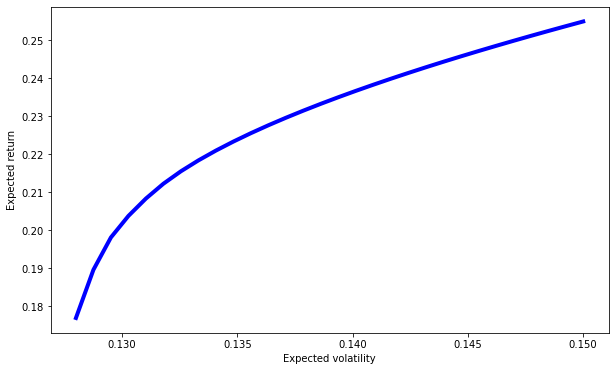

In [31]:
def portfolio_ret(weights):
    return -np.dot(rets.mean(), weights) * 12

def portfolio_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov(), weights)) * 12)

cons = ({'type': 'eq',
         'fun': lambda x: portfolio_vol(x) - target_vol},
        {'type': 'eq',
         'fun': lambda x: np.sum(x) - 1})  

bnds = tuple((0, 1) for x in range(rets.shape[1]))
target_vols = np.linspace(0.128, 0.15, 30)
target_rets = []

for target_vol in target_vols:
    res = sco.minimize(portfolio_ret,
                       [0.1] * rets.shape[1],
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)
    target_rets.append(-res['fun'])
target_rets = np.array(target_rets)

plt.figure(figsize=(10, 6))
plt.plot(target_vols, target_rets,
         'b',
         lw=4.0)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')